In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

In [2]:
market_data = pd.read_excel("../../raw_data/market_data.xlsx")
market_data.drop(index=market_data.index[0], axis=0, inplace=True)
market_data = market_data.reset_index(drop = True)

# Create a period for a whole day which are 48 as
# Spot prices are taken by the 30 minutes mark.
period = []
count = 1
for i in range(1, len(market_data) + 1):
    period.append(count)
    count += 1
    if (i % 48) == 0:
        count = 1
        
market_data['Period'] = pd.Series(period)
market_data['Time (UTC+10)'] = pd.to_datetime(market_data['Time (UTC+10)'])

In [3]:
vic_data = market_data[['Time (UTC+10)','Regions VIC Trading Price ($/MWh)']].copy()
vic_data.set_index('Time (UTC+10)', inplace = True)

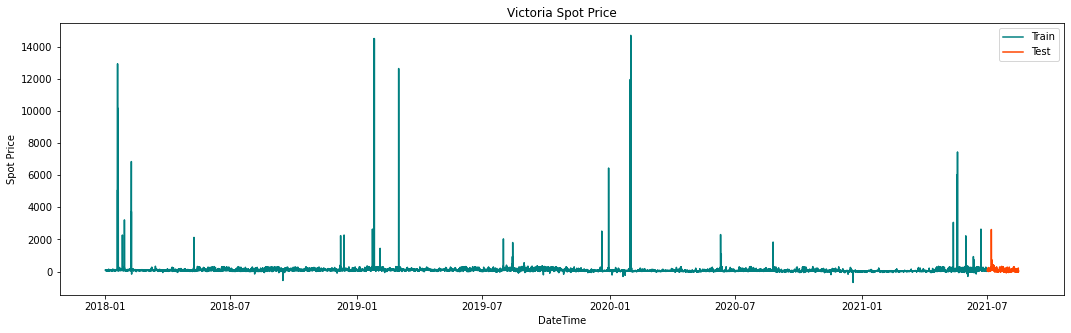

In [4]:
train = vic_data.iloc[:61296, :].copy()
test = vic_data.iloc[61296:, :].copy()

plt.figure(figsize=(18,5))
plt.title('Victoria Spot Price')
plt.plot(train['Regions VIC Trading Price ($/MWh)'], color='teal')
plt.plot(test['Regions VIC Trading Price ($/MWh)'], color='orangered')
plt.legend(['Train','Test'])
plt.xlabel('DateTime')
plt.ylabel('Spot Price')
plt.show()

### Rescaling both Training and Testing dataset

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))

In [6]:
scaled_train = scaler.fit_transform(train.values)
scaled_train

array([[0.05000075],
       [0.04968598],
       [0.04874037],
       ...,
       [0.04790012],
       [0.04879045],
       [0.04735058]])

In [7]:
scaled_test = scaler.fit_transform(test.values)
scaled_test

array([[0.05980948],
       [0.05363473],
       [0.03871119],
       ...,
       [0.03814207],
       [0.03547875],
       [0.02938956]])

### Splitting Training and Testing into features and target variables 

In [8]:
PERIOD = 52

train_data = scaled_train
X_train = []
y_train = []

for i in range(PERIOD, len(train_data)):
    X_train.append(train_data[i - PERIOD:i, 0])
    y_train.append(train_data[i, 0])

In [9]:
test_data = np.concatenate((scaled_train[-PERIOD:], scaled_test), axis=0)

X_test = []
y_test = test
for i in range(PERIOD, len(test_data)):
    X_test.append(test_data[i - PERIOD:i, 0])

### Convert Splitted Dataset into Numpy Arrays and Reshaping

In [10]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Model Training

In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM

### Vanilla LSTM Model with Spot Price

In [12]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [13]:
model.compile(optimizer = 'sgd', loss = 'mse')

In [14]:
model.fit(X_train, y_train, batch_size = 1, epochs = 1)

61244/61244 [==============================] - 403s 7ms/step - loss: 3.6663e-04


### Predictions

In [15]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [16]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

Regions VIC Trading Price ($/MWh)    13.160753
dtype: float64

### Plot the data

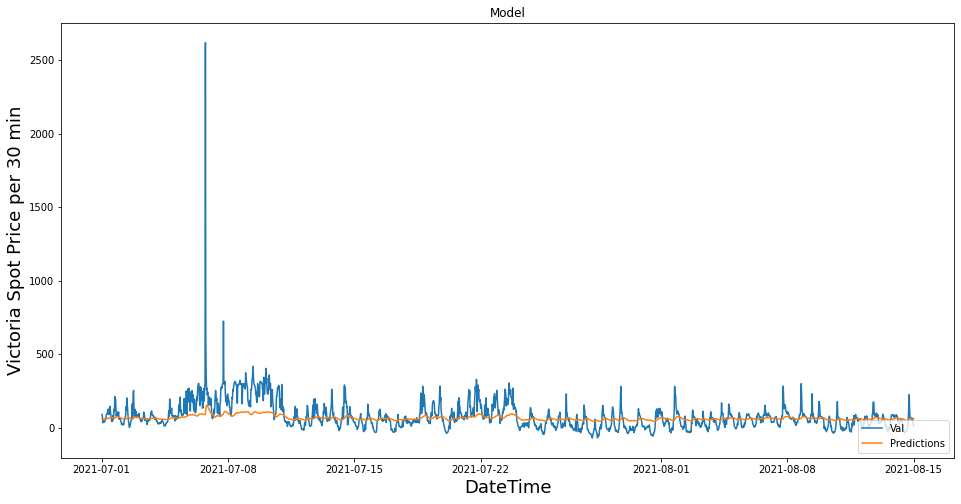

In [19]:
test['Predictions'] = predictions

plt.figure(figsize = (16, 8))
plt.title('Model')
plt.xlabel("DateTime", fontsize = 18)
plt.ylabel("Victoria Spot Price per 30 min", fontsize = 18)
#plt.plot(train['Regions VIC Trading Price ($/MWh)'])
plt.plot(test[['Regions VIC Trading Price ($/MWh)', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc = 'lower right')
plt.show()